In [10]:
import tensorflow as tf
import keras


print("Tensorflow version:", tf.__version__)
print("Keras version:", keras.__version__)

Tensorflow version: 2.16.1
Keras version: 3.3.3


In [11]:
# import matplotlib.pyplot as plt
# from glob import glob
# import random
# import cv2

# images = glob("/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/**/**")
# for i in range (9):
#     Imgae = random.choice(images)
#     plt.figure(figsize=(20,20))
#     plt.subplot(331+i)
#     plt.imshow(cv2.imread(Imgae));plt.axis('off')

In [12]:
import os
dataset_path = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images"

train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

In [13]:
# Check if paths exist
if not os.path.exists(train_dir) or not os.path.exists(test_dir):
    print("Dataset paths do not exist.")
else:
    print("Dataset Sucessfully loaded")

Dataset Sucessfully loaded


## Pre-processing the Dataset

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data preprocessing
IMG_HEIGHT = 32
IMG_WIDTH = 32
BATCH_SIZE = 128

train_datagen = ImageDataGenerator(
                          rescale=1.0/255.0,
                          rotation_range=20,
                          width_shift_range=0.2,
                          height_shift_range=0.2,
                          shear_range=0.2,
                          zoom_range=0.2,
                          horizontal_flip=True,
                          fill_mode='nearest'

)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [15]:
#Load train and test Data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


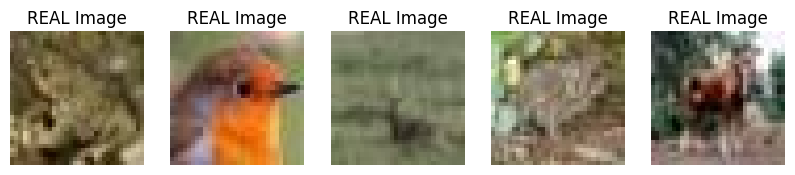

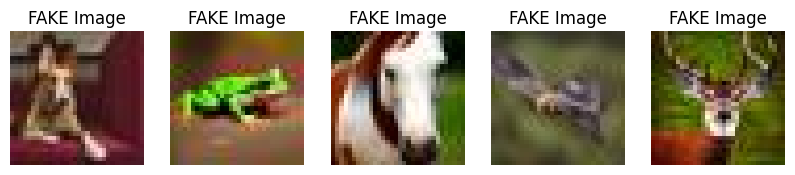

In [16]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Function to display a grid of sample images
def visualize_sample_images(directory, class_name, num_images=5):
    class_dir = os.path.join(directory, class_name)
    image_files = os.listdir(class_dir)[:num_images]

    plt.figure(figsize=(10, 10))

    for i, image_file in enumerate(image_files):
        img_path = os.path.join(class_dir, image_file)
        img = load_img(img_path, target_size=(32, 32))
        img_array = img_to_array(img)

        plt.subplot(1, num_images, i+1)
        plt.imshow(np.uint8(img_array))
        plt.title(f'{class_name} Image')
        plt.axis('off')

    plt.show()

# Example: Visualize images from both classes (REAL and FAKE)
visualize_sample_images(train_dir, 'REAL', num_images=5)
visualize_sample_images(train_dir, 'FAKE', num_images=5)

## Building a CNN model

In [17]:
from tensorflow.keras import layers, models

def build_model():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.5))

  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  return model

model = build_model()
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,041 (621.25 KB)

 Trainable params: 159,041 (621.25 KB)

 Non-trainable params: 0 (0.00 B)

## Model training

In [18]:
EPOCHS = 20

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 200s 249ms/step - accuracy: 0.7260 - loss: 0.5319 - val_accuracy: 0.8154 - val_loss: 0.4001
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 192s 243ms/step - accuracy: 0.8361 - loss: 0.3728 - val_accuracy: 0.7335 - val_loss: 0.7186
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 191s 242ms/step - accuracy: 0.8566 - loss: 0.3331 - val_accuracy: 0.7899 - val_loss: 0.5038
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 188s 238ms/step - accuracy: 0.8675 - loss: 0.3087 - val_accuracy: 0.8001 - val_loss: 0.4973
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 182s 231ms/step - accuracy: 0.8784 - loss: 0.2924 - val_accuracy: 0.7994 - val_loss: 0.5379
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 181s 230ms/step - accuracy: 0.8846 - loss: 0.2742 - val_accuracy: 0.8717 - val_loss: 0.3150
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 187s 237ms/step - accuracy: 0.8936 - loss: 0.2597 - val_accuracy: 0.8932 - val_loss: 0.2510
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 190s 241ms/step - accuracy: 0.8973 -

## Model Evaluation

In [19]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy of Model is: {test_acc}')

157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step - accuracy: 0.8550 - loss: 0.3916
Test accuracy of Model is: 0.8565999865531921


## Model Saving

In [20]:
model.save('real_vs_fake_image_classifier_v1.1.h5')

## Predict with the model

In [21]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_img(img_path, model):
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)
    if prediction[0] > 0.5:
        print("Image is Real")
    else:
        print("Image is AI Generated")

## Plot training history

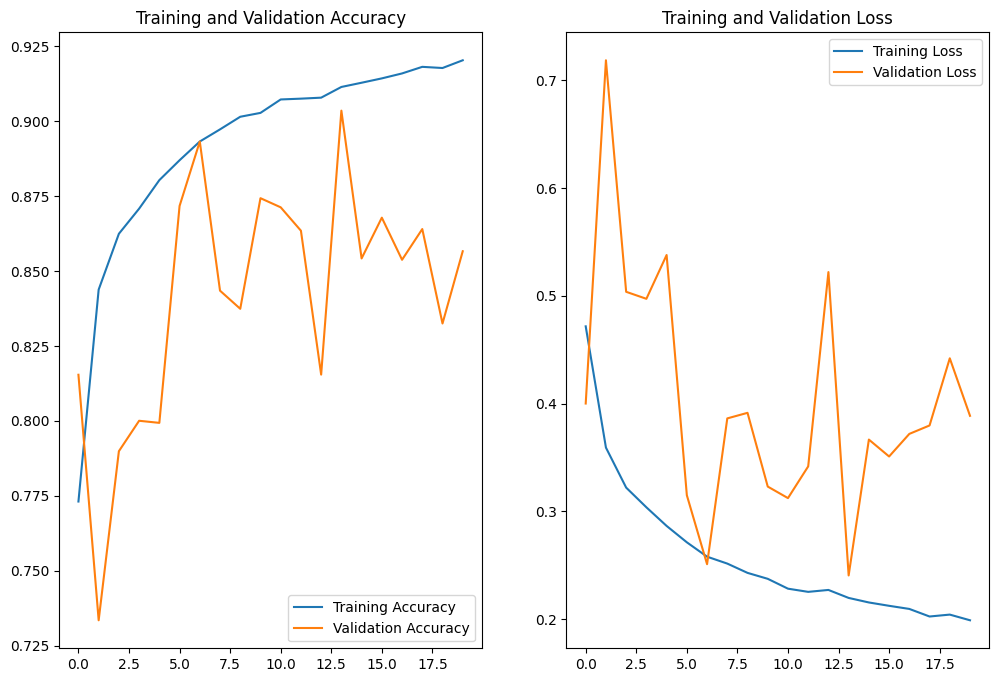

In [22]:
import matplotlib.pyplot as plt

# Plot training accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()